In [1]:
import pandas as pd
import geopandas as gpd
import geocoder
import re 
import mapclassify
from tqdm import tqdm
import pycountry
import pdb
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio
import matplotlib
import matplotlib.patches as mpatches

In [2]:
def testMismatchNameBetweenWorldAndCountries(world):
    """
    test mismatch name between world and countries
    Args:
        world: gpd frame
    """
    not_in_list = []
    ISO3_list = world.ISO3.to_list()
    for c, country in enumerate(pycountry.countries):
        if not country.alpha_3 in ISO3_list:
            not_in_list.append(country.alpha_3)
        else:
            print(country.alpha_3)
    print(not_in_list)



In [3]:

def readWorldFile(path):
    """
    Read world frame from path
    Args:
        path: path to the file
    Return: 
        return the gpd frame
    """
    return gpd.read_file(path)

In [4]:
def preprocessUserLocation(df):
    """
    Read csv dataframe, replace foreign language with english and remove the rows with nan
    Args:
        df: dataframe
    Return: modified df
    """
    df.user_location = df.user_location.str.replace("中国","China", case=False)
    df.user_location = df.user_location.str.replace("ישראל","Israel", case=False)
    df.user_location = df.user_location.str.replace("آزاد کشمیر","Free Kashmir", case=False)
    df.user_location = df.user_location.str.replace("الإمارات العربية المتحدة","United Arab Emirates",case=False)
    df.user_locaiton = df.user_location.str.replace("مصر","Egypt",case=False)
    df.user_location = df.user_location.str.replace("日本","Japan", case=False)
    df.user_location = df.user_location.str.replace("Россия","Russia", case=False)
    df.user_location = df.user_location.str.replace("تونس","Tunisia",case=False)
    df.user_location = df.user_location.str.replace("علی پور چٹھہ، الباکستان", "Pakistan",case=False)
    df.user_location = df.user_location.str.replace("عمان", "Amman", case=False)
    df.user_location = df.user_location.str.replace("قطر", "Qatar", case = False)
    df.user_location = df.user_location.str.replace("لبنان", "Lebanon", case = False)
    df.user_location = df.user_location.str.replace("ኢትዮጵያ", "Ethiopia", case = False)
    df.user_location = df.user_location.str.replace("नेपाल", "Nepal",case=False)
    df.user_location = df.user_location.str.replace("বাংলাদেশ", "Bangladesh", case=False)
    df.user_location = df.user_location.str.replace("ประเทศไทย", "Thailand", case = False)
    df.user_location = df.user_location.str.replace( "ព្រះរាជាណាចក្រ​កម្ពុជា",   "Cambodia", case=False)
    df.user_location = df.user_location.str.replace("대한민국" , "South Korea", case = False)
    df.user_location = df.user_location.str.replace("臺灣", "China",case = False)       
    
    df.dropna(axis=0, how="any", inplace=True)
    return df

In [5]:
def replaceUserLocationWithISO3(df, world):
    """
    Replace user location with ISO3 to make the location information consistant
    Args:
        df: dataframe
        world: gpd frame
    Return:
        modifed dataframe
    """
    
    removeList = []
    good_list = []
    df.loc[:,"ISO3"] = df.loc[:,"user_location"]
    ISO3_list = world.ISO3.to_list()
    N = len(df.index)
    for i in tqdm(df.index):
            foundFlag = False
            row = df.loc[i, 'user_location']
            for c, country in enumerate(pycountry.countries):
                # if the country name is in the current row and its ISO3 representation is the same as the one in world, then we found a match
                if country.name.lower() in row.lower() and country.alpha_3 in ISO3_list:
                    df.loc[i,'ISO3'] = country.alpha_3
                    foundFlag = True
                    break
            if not foundFlag:
                removeList.append(i)
            else:
                good_list.append(i)
    # swap the columns to make the user_location and ISO3 column adjacent to each other
    column_name = df.columns.tolist()
    ISO3_index = column_name.index("ISO3")
    user_location_index = column_name.index("user_location")
    i, j =min(ISO3_index, user_location_index), max(ISO3_index, user_location_index)
    column_name = column_name[:i+1]+column_name[j:j+1]+column_name[i+1:j]+column_name[j+1:]
    df = df[df.index.isin(good_list)][column_name]
    
    print("You have found {}/{} data samples".format(len(df), N))
    return df

In [6]:
def main(world_path=r"country.shp", vaccine_file_path="vaccination_all_tweets.csv", sentiment_score_file_path="tweet_sentiment_001.csv"):
    """
    Main function
    """
    world = readWorldFile(world_path)
    #testMismatchNameBetweenWorldAndCountries(world)
    df_total = pd.read_csv(vaccine_file_path)
    # read the preprocessed sentiment analysis result from another csv file
    df_score = pd.read_csv(sentiment_score_file_path)
    # preprocess the original vaccine file
    # only keep the month-day-year
    df_total.date = df_total.date.str.split().str[0]
    # preprocess and replace the foreign language with English
    df_total = preprocessUserLocation(df_total)
    # associate the country name with the ISO3
    df_total = replaceUserLocationWithISO3(df_total, world)
    

    # list of uniques dates for all the records
    dates = sorted(df_total.date.str.split().str[0].unique().tolist())
    for i, date in enumerate(dates):
        df = df_total[df_total.date==date]
        # group the data by the country name (ISO3) and calculate the mean score
        df = pd.merge(df, df_score, on="id")[["score", "ISO3"]]
        if len(df)<50 or abs(max(df.score)-min(df.score))<1e-5:
            continue
        
        df = df.groupby("ISO3").mean()
        df.loc[:,"ISO3"] = df.index
        # for all the unknown countries fill in the -1 so we can still see the country in the map
        unknown_ISO3_list = [x for x in world.ISO3.tolist() if x not in df.ISO3.tolist()]
        temp =pd.DataFrame(unknown_ISO3_list, columns=["ISO3"])
        df.index = range(len(df))
        df_padded = pd.concat([temp, df]).fillna(-1)

        merged_world = world.merge(df_padded, left_on="ISO3", right_on="ISO3")
        ax = plotWorldWithScores(merged_world)
        ax.set_title('Dates:' + date,fontdict = {'fontsize':16},pad=12)
        if not os.path.exists("img"):
            os.makedirs("img")
        plt.savefig(f"img/{i}.png")
    #df.to_csv('vaccination_all_tweets_test.csv',index =False)



In [7]:
def plotWorldWithScores(merged_world):
    """
    Plot the world with scores
    Args:
        merged_world: merged gpd frame between data and world
    """
    # -1 means unknown countries, all the other values corresponds to the mean sentiment score for that country
    MAX = max(merged_world.score)
    MIN = min(merged_world.score)
    step = (MAX-MIN)/ 5
    ax = merged_world.plot(column="score", cmap= matplotlib.colors.LinearSegmentedColormap.from_list("", ['#F2C6C6','#ff5555', '#ffaa00','#66b3ff','#33ffdd','#33ff33',]), legend=False,  edgecolor="black", linewidth=0.5,
                      scheme="UserDefined", classification_kwds={'bins': np.arange(MIN, MAX, step).tolist()},
                      )
    pop_a = mpatches.Patch(color='#F2C6C6')
    pop_b = mpatches.Patch(color='#ff5555')
    pop_c = mpatches.Patch(color='#ffaa00')
    pop_d = mpatches.Patch(color='#66b3ff')
    pop_e = mpatches.Patch(color='#33ffdd')
    pop_f = mpatches.Patch(color='#33ff33')
    plt.axis('off')

    plt.legend(handles=[pop_a,pop_b,pop_c,pop_d,pop_e, pop_f], bbox_to_anchor=(0, 1))
    return ax

In [8]:
def generateGif(dir_path="img", gif_save_path="1.gif"):
    """
    Generate the Gif
    Args:
        dir_path: path for the saved images
        gif_save_path: path to save gif 
    """
    files = os.listdir(dir_path)
    #files = sorted(files, key=lambda x: x.split(".")[0])
    y = [(x, int(x.split(".")[0])) for x in files if len(x)>=1 and "png" in x]
    files = sorted(y, key=lambda x: x[1])
    files = [x[0] for x in files]
    path_list = [os.path.join(dir_path, x) for x in files if "png" in x]
    imgs = []
    for path in path_list:
        imgs.append(plt.imread(path))
    imageio.mimsave(gif_save_path, imgs,duration = 0.5)



<ipython-input-4-fe133c5cafea>:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.user_locaiton = df.user_location.str.replace("مصر","Egypt",case=False)
100%|██████████| 9847/9847 [00:04<00:00, 2182.00it/s]


You have found 5638/9847 data samples


/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:589: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:589: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:589: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed an

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


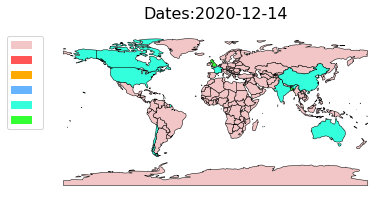

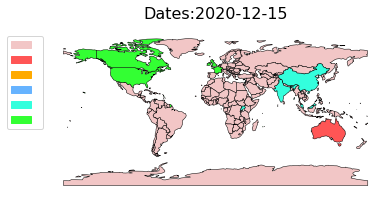

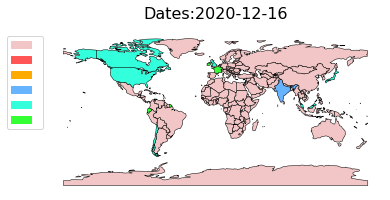

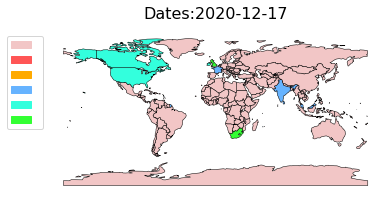

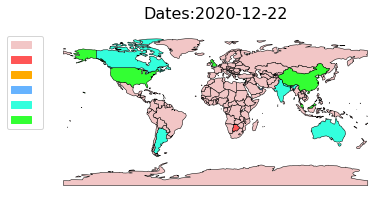

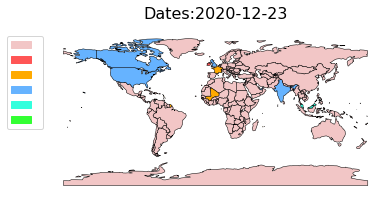

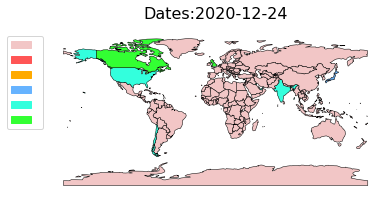

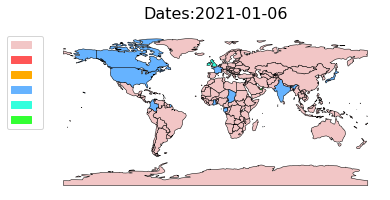

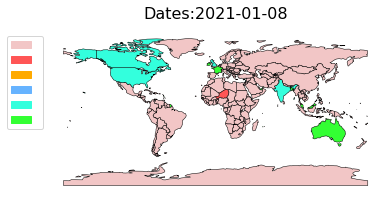

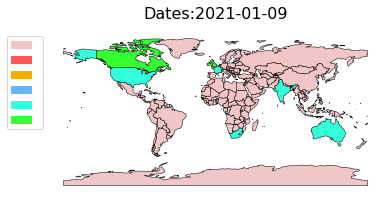

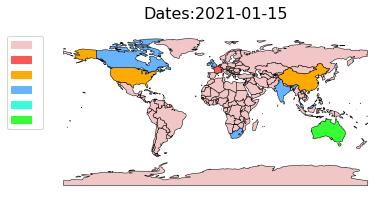

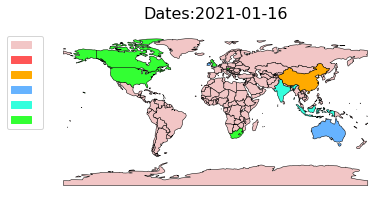

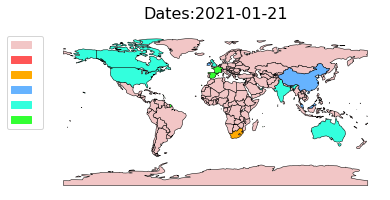

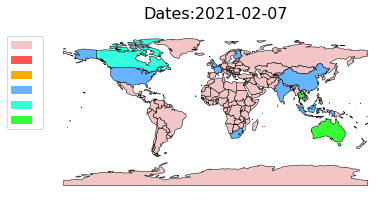

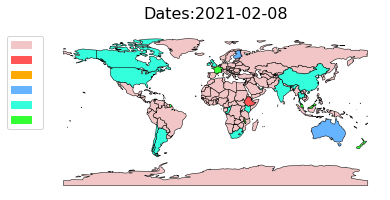

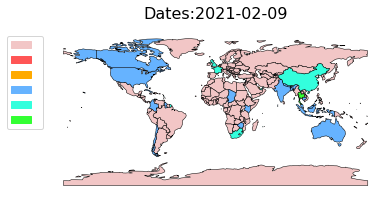

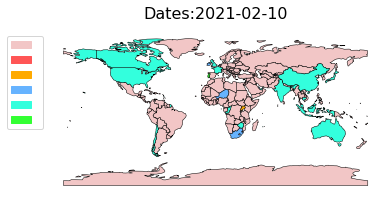

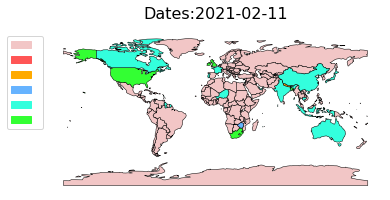

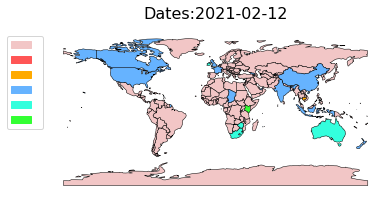

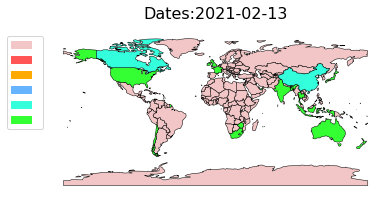

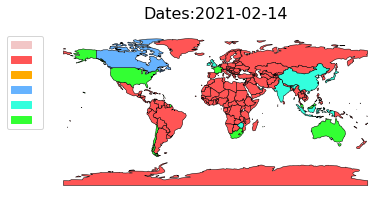

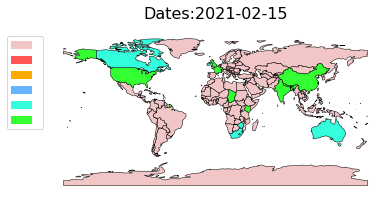

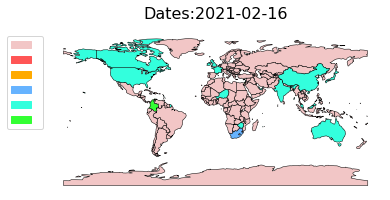

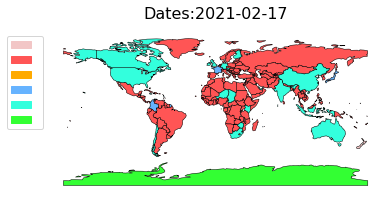

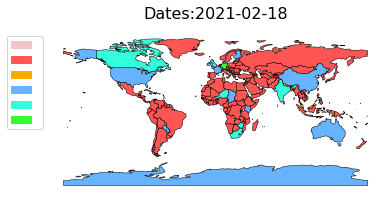

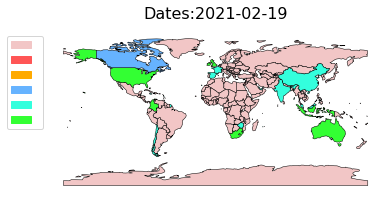

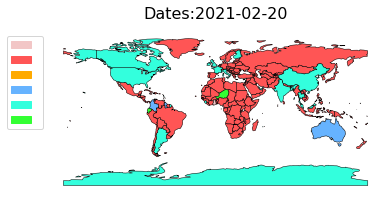

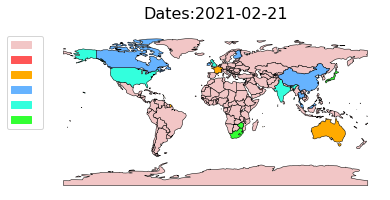

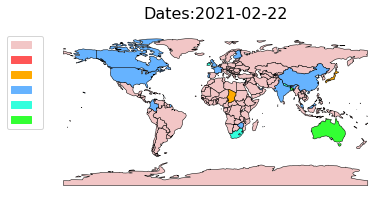

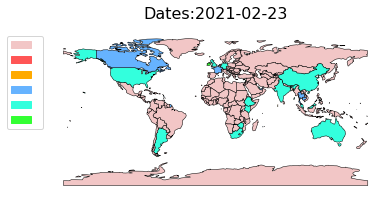

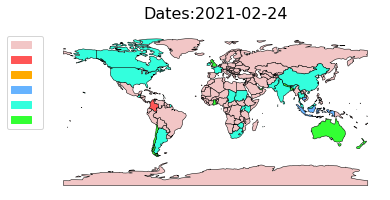

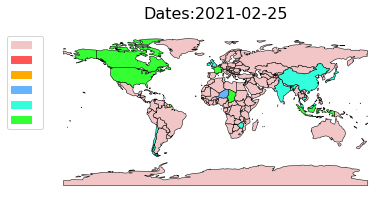

In [9]:
if __name__=="__main__":
    main(world_path=r"data/country.shp", vaccine_file_path="data/vaccination_all_tweets.csv", sentiment_score_file_path="data/tweet_sentiment_all_001.csv")
    generateGif()